In [270]:
import os
import cv2
import glob
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from keras import models
from keras.layers import BatchNormalization,MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam

In [271]:
# Define data paths

no_tumor_dir = Path("dataset/no")
yes_tumor_dir = Path("dataset/yes")
pred_dir = Path("dataset/pred")

In [272]:
# Load image paths and labels

no_jpg_path = list(no_tumor_dir.glob(r"*.jpg"))
yes_jpg_path = list(yes_tumor_dir.glob(r"*.jpg"))

In [273]:
print(no_jpg_path[0:2])

[WindowsPath('dataset/no/no0.jpg'), WindowsPath('dataset/no/no1.jpg')]


In [274]:
print(yes_jpg_path[0:2])

[WindowsPath('dataset/yes/y0.jpg'), WindowsPath('dataset/yes/y1.jpg')]


In [277]:
yes_no_list = []

for No_JPG in no_jpg_path:
    yes_no_list.append(No_JPG)
    
for Yes_JPG in yes_jpg_path:
    yes_no_list.append(Yes_JPG)

In [278]:
print(yes_no_list[0:10])

[WindowsPath('dataset/no/no0.jpg'), WindowsPath('dataset/no/no1.jpg'), WindowsPath('dataset/no/no10.jpg'), WindowsPath('dataset/no/no100.jpg'), WindowsPath('dataset/no/no1000.jpg'), WindowsPath('dataset/no/no1001.jpg'), WindowsPath('dataset/no/no1002.jpg'), WindowsPath('dataset/no/no1003.jpg'), WindowsPath('dataset/no/no1004.jpg'), WindowsPath('dataset/no/no1005.jpg')]


In [279]:
JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],yes_no_list))

In [280]:
print(JPG_Labels[0:10])

['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']


In [282]:
print("Total NO Tumor Images: ", JPG_Labels.count("no"))
print("Total YES Tumor Images: ", JPG_Labels.count("yes"))

Total NO Tumor Images:  1500
Total YES Tumor Images:  1500


In [283]:
JPG_Path_Series = pd.Series(yes_no_list,name="JPG").astype(str)
JPG_Category_Series = pd.Series(JPG_Labels,name="TUMOR_CATEGORY")

In [284]:
Main_Train_Data = pd.concat([JPG_Path_Series,JPG_Category_Series],axis=1)

In [285]:
print(Main_Train_Data.head(-1))

                        JPG TUMOR_CATEGORY
0        dataset\no\no0.jpg             no
1        dataset\no\no1.jpg             no
2       dataset\no\no10.jpg             no
3      dataset\no\no100.jpg             no
4     dataset\no\no1000.jpg             no
...                     ...            ...
2994   dataset\yes\y994.jpg            yes
2995   dataset\yes\y995.jpg            yes
2996   dataset\yes\y996.jpg            yes
2997   dataset\yes\y997.jpg            yes
2998   dataset\yes\y998.jpg            yes

[2999 rows x 2 columns]


In [286]:
# Load test data

Test_JPG_Path = list(pred_dir.glob(r"*.jpg"))

In [287]:
print(Test_JPG_Path[0:5])

[WindowsPath('dataset/pred/pred0.jpg'), WindowsPath('dataset/pred/pred1.jpg'), WindowsPath('dataset/pred/pred10.jpg'), WindowsPath('dataset/pred/pred11.jpg'), WindowsPath('dataset/pred/pred12.jpg')]


In [288]:
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [289]:
print(Test_JPG_Labels[0:5])

['pred', 'pred', 'pred', 'pred', 'pred']


In [290]:
Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)
Test_JPG_Labels_Series = pd.Series(Test_JPG_Labels,name="TUMOR_CATEGORY")

In [291]:
Test_Data = pd.concat([Test_JPG_Path_Series,Test_JPG_Labels_Series],axis=1)

In [292]:
print(Test_Data.head())

                       JPG TUMOR_CATEGORY
0   dataset\pred\pred0.jpg           pred
1   dataset\pred\pred1.jpg           pred
2  dataset\pred\pred10.jpg           pred
3  dataset\pred\pred11.jpg           pred
4  dataset\pred\pred12.jpg           pred


In [293]:
# Shuffle data

In [309]:
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)

In [310]:
print(Main_Train_Data.head(-1))

                        JPG TUMOR_CATEGORY
0      dataset\no\no882.jpg             no
1      dataset\yes\y651.jpg            yes
2      dataset\yes\y148.jpg            yes
3      dataset\no\no254.jpg             no
4      dataset\yes\y468.jpg            yes
...                     ...            ...
2994   dataset\yes\y502.jpg            yes
2995  dataset\yes\y1330.jpg            yes
2996    dataset\no\no94.jpg             no
2997  dataset\yes\y1351.jpg            yes
2998   dataset\yes\y628.jpg            yes

[2999 rows x 2 columns]


In [311]:
## VISUALIZATION

Text(0.5, 1.0, 'no')

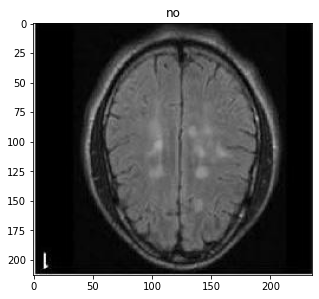

In [312]:
figure = plt.figure(figsize=(5,5))
plt.imshow(plt.imread(Main_Train_Data["JPG"][10]))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][10])

Text(0.5, 1.0, 'yes')

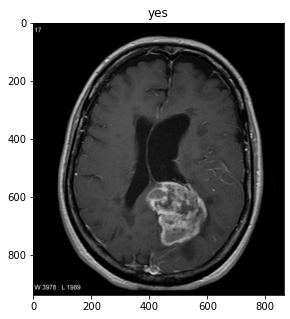

In [313]:
figure = plt.figure(figsize=(5,5))
plt.imshow(plt.imread(Main_Train_Data["JPG"][2997]))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][2997])

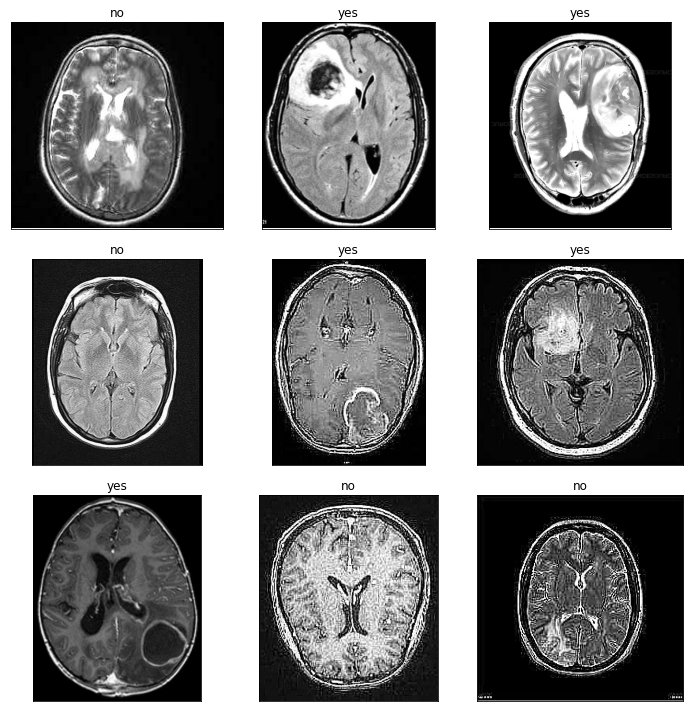

In [315]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Train_Data["JPG"][i]))
    ax.set_title(Main_Train_Data["TUMOR_CATEGORY"][i])
plt.tight_layout()
plt.show()

In [316]:
# MODEL TRAINING DATA: Split data into train and validation sets

In [317]:
train_data,test_data = train_test_split(Main_Train_Data,train_size=0.8,random_state=42)

In [318]:
print(train_data.shape)

(2400, 2)


In [319]:
print(train_data.head())

                       JPG TUMOR_CATEGORY
642   dataset\yes\y524.jpg            yes
700   dataset\yes\y446.jpg            yes
226   dataset\no\no478.jpg             no
1697  dataset\no\no142.jpg             no
1010  dataset\no\no269.jpg             no


In [320]:
print(test_data.shape)

(600, 2)


In [321]:
print(test_data.head())

                        JPG TUMOR_CATEGORY
1801   dataset\yes\y165.jpg            yes
1190   dataset\no\no116.jpg             no
1817   dataset\no\no412.jpg             no
251   dataset\no\no1249.jpg             no
2505   dataset\no\no590.jpg             no


In [322]:
## IMAGE PRE-PROCESSING using CLAHE

In [323]:
def clahe_preprocess(image):
    # Check number of color channels
    if image.shape[-1] == 3:
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Create a CLAHE object
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        # Apply CLAHE to grayscale image
        gray = clahe.apply(gray)
        # Convert grayscale image back to three-channel color image
        image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    return image

In [324]:
def advanced_thresholding(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur to the grayscale image
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply Otsu's Thresholding to the blurred grayscale image
    _, threshold = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Apply Closing to the thresholded image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)
    # Apply Dilation to the closed image
    dilation = cv2.dilate(closed, kernel, iterations=3)
    return dilation

In [325]:
## IMAGE DATA GENERATOR

In [326]:
Generator_Basic = ImageDataGenerator(rescale=1./255, validation_split=0.1, preprocessing_function=clahe_preprocess)

In [327]:
Train_Set = Generator_Basic.flow_from_dataframe(dataframe=train_data,
                                               x_col="JPG",
                                               y_col="TUMOR_CATEGORY",
                                               color_mode="grayscale",
                                               class_mode="categorical",
                                               subset="training",
                                               batch_size=20,
                                               target_size=(200,200),
                                               thresholding_function=advanced_thresholding,
                                               thresholding_args={'block_size': 101, 'constant': 2})

Found 2160 validated image filenames belonging to 2 classes.


In [328]:
Validation_Set = Generator_Basic.flow_from_dataframe(dataframe=train_data,
                                                     x_col="JPG",
                                                     y_col="TUMOR_CATEGORY",
                                                     color_mode="grayscale",
                                                     class_mode="categorical",
                                                     subset="validation",
                                                     batch_size=20,
                                                     target_size=(200,200),
                                                     thresholding_function=advanced_thresholding,
                                                     thresholding_args={'block_size': 101, 'constant': 2})

Found 240 validated image filenames belonging to 2 classes.


In [329]:
Test_Set = Generator_Basic.flow_from_dataframe(dataframe=test_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              color_mode="grayscale",
                                              class_mode="categorical",
                                              batch_size=20,
                                              target_size=(200,200),
                                              thresholding_function=advanced_thresholding,
                                              thresholding_args={'block_size': 101, 'constant': 2})

Found 600 validated image filenames belonging to 2 classes.


In [330]:
for data_batch,label_batch in Train_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 200, 200, 1)
LABEL SHAPE:  (20, 2)


In [331]:
for data_batch,label_batch in Validation_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 200, 200, 1)
LABEL SHAPE:  (20, 2)


In [332]:
for data_batch,label_batch in Test_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 200, 200, 1)
LABEL SHAPE:  (20, 2)


In [333]:
print(Train_Set.class_indices)
print(Train_Set.classes[0:5])
print(Train_Set.image_shape)

{'no': 0, 'yes': 1}
[1, 0, 1, 1, 0]
(200, 200, 1)


In [334]:
print(Validation_Set.class_indices)
print(Validation_Set.classes[0:5])
print(Validation_Set.image_shape)

{'no': 0, 'yes': 1}
[1, 1, 0, 0, 0]
(200, 200, 1)


In [335]:
print(Test_Set.class_indices)
print(Test_Set.classes[0:5])
print(Test_Set.image_shape)

{'no': 0, 'yes': 1}
[1, 0, 0, 0, 0]
(200, 200, 1)


In [336]:
# define the ImageDataGenerator with advanced thresholding
Generator_Thresholding = ImageDataGenerator(rescale=1./255,
                                             validation_split=0.1,
                                             preprocessing_function=advanced_thresholding)

In [337]:
# create the train, validation and test sets using the advanced thresholding ImageDataGenerator
Train_Set_Thresholding = Generator_Thresholding.flow_from_dataframe(dataframe=train_data,
                                               x_col="JPG",
                                               y_col="TUMOR_CATEGORY",
                                               color_mode="grayscale",
                                               class_mode="categorical",
                                               subset="training",
                                               batch_size=20,
                                               target_size=(200,200))

Found 2160 validated image filenames belonging to 2 classes.


In [338]:
Validation_Set_Thresholding = Generator_Thresholding.flow_from_dataframe(dataframe=train_data,
                                                     x_col="JPG",
                                                     y_col="TUMOR_CATEGORY",
                                                     color_mode="grayscale",
                                                     class_mode="categorical",
                                                     subset="validation",
                                                     batch_size=20,
                                                     target_size=(200,200))

Found 240 validated image filenames belonging to 2 classes.


In [340]:
Test_Set_Thresholding = Generator_Thresholding.flow_from_dataframe(dataframe=test_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              color_mode="grayscale",
                                              class_mode="categorical",
                                              batch_size=20,
                                              target_size=(200,200))

Found 600 validated image filenames belonging to 2 classes.


In [341]:
## CNN MODEL

In [342]:
Model = Sequential()

Model.add(Conv2D(32,(5,5),activation="relu",input_shape=(200,200,1)))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(64,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(128,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(256,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Flatten())
Model.add(Dropout(0.5))
Model.add(Dense(512,activation="relu"))
Model.add(Dense(2,activation="softmax"))

In [343]:
## MODEL COMPILE

In [344]:
Model.compile(optimizer=RMSprop(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

In [347]:
# MODEL FITTING
CNN_Model = Model.fit(Train_Set,validation_data=Validation_Set,
                      epochs=30,steps_per_epoch=80)

Epoch 1/30
80/80 [==============================] - 55s 681ms/step - loss: 0.3537 - accuracy: 0.8587 - val_loss: 0.3031 - val_accuracy: 0.8667
Epoch 2/30
80/80 [==============================] - 65s 814ms/step - loss: 0.3025 - accuracy: 0.8750 - val_loss: 0.2643 - val_accuracy: 0.8917
Epoch 3/30
80/80 [==============================] - 64s 801ms/step - loss: 0.2439 - accuracy: 0.9050 - val_loss: 0.1956 - val_accuracy: 0.9167
Epoch 4/30
80/80 [==============================] - 68s 844ms/step - loss: 0.1937 - accuracy: 0.9175 - val_loss: 0.1965 - val_accuracy: 0.9292
Epoch 5/30
80/80 [==============================] - 73s 916ms/step - loss: 0.1896 - accuracy: 0.9312 - val_loss: 0.1940 - val_accuracy: 0.9208
Epoch 6/30
80/80 [==============================] - 70s 870ms/step - loss: 0.1572 - accuracy: 0.9394 - val_loss: 0.1433 - val_accuracy: 0.9375
Epoch 7/30
80/80 [==============================] - 77s 961ms/step - loss: 0.1101 - accuracy: 0.9625 - val_loss: 0.2005 - val_accuracy: 0.9250

In [348]:
print(Model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 196, 196, 32)      832       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 98, 98, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 98, 98, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 48, 48, 64)       

In [349]:
HistoryDict = CNN_Model.history

val_losses = HistoryDict["val_loss"]
val_acc = HistoryDict["val_accuracy"]
acc = HistoryDict["accuracy"]
losses = HistoryDict["loss"]
epochs = range(1,len(val_losses)+1)

No handles with labels found to put in legend.


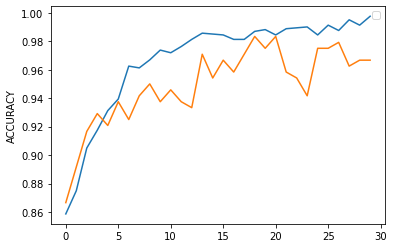

In [350]:
plt.plot(CNN_Model.history["accuracy"])
plt.plot(CNN_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

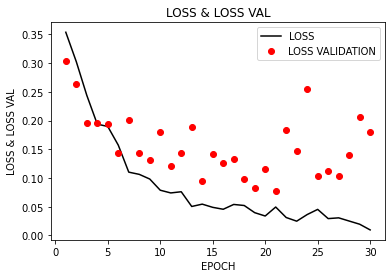

In [351]:
plt.plot(epochs,losses,"k-",label="LOSS")
plt.plot(epochs,val_losses,"ro",label="LOSS VALIDATION")
plt.title("LOSS & LOSS VAL")
plt.xlabel("EPOCH")
plt.ylabel("LOSS & LOSS VAL")
plt.legend()
plt.show()

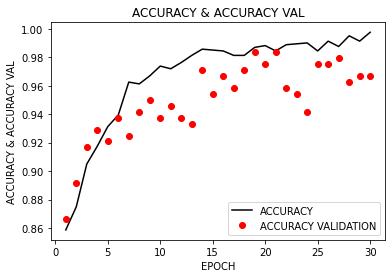

In [352]:
plt.plot(epochs,acc,"k-",label="ACCURACY")
plt.plot(epochs,val_acc,"ro",label="ACCURACY VALIDATION")
plt.title("ACCURACY & ACCURACY VAL")
plt.xlabel("EPOCH")
plt.ylabel("ACCURACY & ACCURACY VAL")
plt.legend()
plt.show()

<AxesSubplot:>

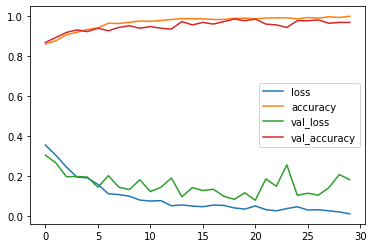

In [353]:
Dict_Summary = pd.DataFrame(CNN_Model.history)
Dict_Summary.plot()

In [354]:
# PREDICTION SCORE ON DIVIDED DATA

In [355]:
Model_Results = Model.evaluate(Test_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])

LOSS:  0.1279
ACCURACY:  0.98


In [356]:
# PREDICTION PROCESS
Main_Data_Prediction = pd.DataFrame({"JPG":Test_JPG_Path_Series})
print(Main_Data_Prediction.head())


                       JPG
0   dataset\pred\pred0.jpg
1   dataset\pred\pred1.jpg
2  dataset\pred\pred10.jpg
3  dataset\pred\pred11.jpg
4  dataset\pred\pred12.jpg


In [357]:
Main_Test_Generator = ImageDataGenerator(rescale=1./255)


In [358]:
Main_Test_Set = Main_Test_Generator.flow_from_dataframe(dataframe=Main_Data_Prediction,
                                                       x_col="JPG",
                                                       y_col=None,
                                                       color_mode="grayscale",
                                                        class_mode=None,
                                                        batch_size=20,
                                                        target_size=(200,200))


Found 60 validated image filenames.


In [359]:
Model_Test_Prediction = Model.predict(Main_Test_Set)


3/3 [==============================] - 1s 142ms/step


In [360]:
Model_Test_Prediction = Model_Test_Prediction.argmax(axis=-1)


In [361]:

print(Model_Test_Prediction)


[0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1]


In [362]:
Last_Prediction = []
[Last_Prediction.append('NO') if i == 1 else Last_Prediction.append('TUMOR') for i in Model_Test_Prediction]
print(Last_Prediction)

['TUMOR', 'NO', 'TUMOR', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'NO', 'NO', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'NO', 'NO', 'TUMOR', 'TUMOR', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'NO', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'NO']


In [372]:
# fig, axes = plt.subplots(nrows=5,
#                          ncols=5,
#                          figsize=(20, 20),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(Main_Data_Prediction["JPG"].loc[i]))
#     ax.set_title(f"PREDICTION:{Last_Prediction[i]}")
# plt.tight_layout()
# plt.show()

In [364]:
from keras.models import load_model

In [365]:
Model.save("brain_tumor_predictor.h5")

In [366]:
import tensorflow as tf
import cv2
import numpy as np

# Load the saved model
model = tf.keras.models.load_model("brain_tumor_predictor.h5")

# Read the input image
img = cv2.imread("dataset/pred/pred49.jpg")

# Resize and convert the image to grayscale
img = cv2.resize(img, (200, 200))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=-1)
img = np.expand_dims(img, axis=0)

# Make predictions on the image
pred = model.predict(img)

# Extract the predicted class (0 = no tumor, 1 = tumor)
pred_class = np.argmax(pred, axis=1)

# Print the predicted class
if pred_class[0] == 0:
    print("No Tumor Detected.")
else:
    print("Tumor Detected!")

1/1 [==============================] - 0s 168ms/step
No Tumor Detected.


In [371]:
import tensorflowjs as tfjs

ModuleNotFoundError: No module named 'tensorflowjs'

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()